In [47]:
from BfTableGenerator import *
from DDBSCAN import Raster_DBSCAN
import os
import matplotlib.pyplot as plt

In [72]:
class RectangleData():

    def __init__(self):
        self.a = [None] * 4
        self.b = [None] * 4
        self.c = [None] * 4

        self.rect_c_x = [None] * 5
        self.rect_c_y = [None] * 5

    def plot(self):
        self.calc_rect_contour()
        plt.plot(self.rect_c_x, self.rect_c_y, "-r")

    def calc_rect_contour(self):

        self.rect_c_x[0], self.rect_c_y[0] = self.calc_cross_point(self.a[0:2], self.b[0:2], self.c[0:2])

        self.rect_c_x[1], self.rect_c_y[1] = self.calc_cross_point(self.a[1:3], self.b[1:3], self.c[1:3])
        
        self.rect_c_x[2], self.rect_c_y[2] = self.calc_cross_point(self.a[2:4], self.b[2:4], self.c[2:4])
        
        self.rect_c_x[3], self.rect_c_y[3] = self.calc_cross_point([self.a[3], self.a[0]], [self.b[3], self.b[0]], [self.c[3], self.c[0]])
        
        self.rect_c_x[4], self.rect_c_y[4] = self.rect_c_x[0], self.rect_c_y[0]

    def calc_cross_point(self, a, b, c):
        x = (b[0] * -c[1] - b[1] * -c[0]) / (a[0] * b[1] - a[1] * b[0])
        y = (a[1] * -c[0] - a[0] * -c[1]) / (a[0] * b[1] - a[1] * b[0])
        return x, y

In [64]:
theta_raw = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])[:,0]
theta = np.sort(theta_raw)
azimuths = np.arange(0,360,0.2)


In [68]:
def _calc_closeness_criterion(c1, c2):
    
    min_dist_of_closeness_crit = 0.01
    c1_max = max(c1)
    c2_max = max(c2)
    c1_min = min(c1)
    c2_min = min(c2)

    D1 = [min([np.linalg.norm(c1_max - ic1),
               np.linalg.norm(ic1 - c1_min)]) for ic1 in c1]
    D2 = [min([np.linalg.norm(c2_max - ic2),
               np.linalg.norm(ic2 - c2_min)]) for ic2 in c2]

    beta = 0
    for i, _ in enumerate(D1):
        d = max(min([D1[i], D2[i]]), min_dist_of_closeness_crit)
        beta += (1.0 / d)

    return beta

In [450]:
A = np.array([[1,1],
          [2,1]])
B = np.array([[1,1],
          [2,1]])

In [187]:
def _rectangle_search(X):
    
        # X:2D array (n,2)
        dtheta = np.deg2rad(10)
        minp = (-float('inf'), None)
        for theta in np.arange(0.0, np.pi / 2.0 - dtheta, dtheta):

            e1 = np.array([np.cos(theta), np.sin(theta)])
            e2 = np.array([-np.sin(theta), np.cos(theta)])

            c1 = X @ e1.T
            c2 = X @ e2.T

            # Select criteria
            cost = _calc_closeness_criterion(c1, c2)

            if minp[0] < cost:
                minp = (cost, theta)

        # calculate best rectangle
        sin_s = np.sin(minp[1])
        cos_s = np.cos(minp[1])

        c1_s = X @ np.array([cos_s, sin_s]).T
        c2_s = X @ np.array([-sin_s, cos_s]).T

        rect = RectangleData()
        rect.a[0] = cos_s
        rect.b[0] = sin_s
        rect.c[0] = min(c1_s)
        rect.a[1] = -sin_s
        rect.b[1] = cos_s
        rect.c[1] = min(c2_s)
        rect.a[2] = cos_s
        rect.b[2] = sin_s
        rect.c[2] = max(c1_s)
        rect.a[3] = -sin_s
        rect.b[3] = cos_s
        rect.c[3] = max(c2_s)

        return rect

In [49]:
def convert_point_cloud(Td_map, Labeling_map, Thred_map): 
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):

        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<Thred_map[i])

        # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])

        Labels.append(Labeling_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    return XYZ, Labels

In [727]:
params = {
        'd':1.2,
        'thred_s':0.3,
        'N':20,
        'delta_thred' : 1e-3,
        'step':0.1,
        'win_size':(5,11),
        'eps': 1.75,
        'min_samples':15,
        'missing_thred':7,
        'ending_frame' : 17950,
        'background_update_frame':2000,
        'save_pcd' : None,
        'save_Azimuth_Laser_info' : False,
        'result_type':'merged'
    }

In [13]:
input_path = '../RawLidarData/Veteran'
dir_lis = os.listdir(input_path)
pcap_path = 'None'
for f in dir_lis:
    if 'pcap' in f.split('.'):
        pcap_path = os.path.join(input_path,f)
if pcap_path == 'None':
    print('Pcap file is not detected')
output_file_path = '../RawLidarData/Veteran'


In [14]:
data_collector = RansacCollector(pcap_path,output_file_path,background_update_frame)

In [15]:
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()

In [16]:
background_update_frame = 2000 

In [17]:
aggregated_maps = []
for i in tqdm(range(background_update_frame)):
    one_frame = next(frame_gen)
    aggregated_maps.append(one_frame)
aggregated_maps = np.array(aggregated_maps) # 1800 * 32 * len(ts)
data_collector.aggregated_map = aggregated_maps
data_collector.gen_thredmap(params['d'],params['thred_s'],params['N'],params['delta_thred'],params['step'])
thred_map = data_collector.thred_map

100%|██████████| 2000/2000 [01:27<00:00, 22.97it/s]


Generating Threshold Map


In [27]:
db = Raster_DBSCAN(window_size=params['win_size'],eps = params['eps'],
                   min_samples= params['min_samples'],Td_map_szie=thred_map.shape)   

In [679]:
Td_map = next(frame_gen)
Foreground_map = (Td_map < thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
unique_labels = np.unique(Labeling_map)[1:]

In [31]:
def extract_xylwh_by_frame(Labeling_map,Td_map,Thred_map):
    
    XYZ,Labels = convert_point_cloud(Td_map,Labeling_map,Thred_map)
    if -1 in Labels:
        unique_id = np.unique(Labels)[1:]
    else:
        unique_id = np.unique(Labels)
    
    xylwh_set = []  
    for l in unique_id:
        xylwh = get_params_from_detection_points(Td_map,Labeling_map,l,Thred_map)
        xylwh_set.append(xylwh)
    
    return np.array(xylwh_set),unique_id

In [32]:
def get_params_from_detection_points(Td_map,Labeling_map,Label,Thred_map):
    
    XYZ,Labels = convert_point_cloud(Td_map,Labeling_map,Thred_map)
    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(XYZ[Labels == Label])
    bbox = pcd.get_axis_aligned_bounding_box()
    # x,y,length,width,height 
    xylwh = np.concatenate([bbox.get_center()[:2],bbox.get_max_bound() - bbox.get_min_bound()])
    return xylwh

In [146]:
def convert_point_cloud(Td_map, Labeling_map, Thred_map): 
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):

        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<Thred_map[i])

        # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])

        Labels.append(Labeling_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    return XYZ, Labels

In [199]:
def cal_single_point_coord(row,col,Td_map):
    longitudes = theta[row]*np.pi / 180
    latitudes = azimuths[col] * np.pi / 180 
    hypotenuses = Td_map[row,col] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    return X,Y

In [617]:
def cal_angle(v1,v2):
    dot = np.sum(v1*v2)
    det = v1[0]*v2[1] - v1[1]*v2[0]
    return np.arctan2(det,dot)

def get_line_param(p1,p2):
    a = p2[:,1] - p1[1]
    b = p1[0] - p2[:,0]
    c = p2[:,0]*p1[1] - p1[0]*p2[:,1]
    return np.array([a,b,c]).T

def get_line_param_single(p1,p2):
    a = p2[1] - p1[1]
    b = p1[0] - p2[0]
    c = p2[0]*p1[1] - p1[0]*p2[1]
    return a,b,c

def perpendicular_dis(x,y,a,b,c):
    # x,y should be array
    d = np.abs(a * x + b * y + c)/np.sqrt(a**2 + b**2)
    return d 

In [732]:
resolution = np.pi*2/180 # rad
grinds = np.arange(0.1,np.pi,resolution)
deltathred = 0.1
vec_x = np.array([radius,0])
l = 0

In [614]:
XYZ,Labels = convert_point_cloud(Td_map,Labeling_map,thred_map)
Ground_truth_coord = XYZ[Labels == l][:,:2]

In [615]:
rows,cols = np.where(Labeling_map == l)
unique_cols = np.unique(cols)
if (unique_cols[0] == 0)&(unique_cols[-1] == 1799):# roll over
    unique_cols[unique_cols < 899] += 1800
    unique_cols = np.sort(unique_cols)
    candi_col_a,candi_col_b = unique_cols[0],unique_cols[-1]-1800
else:
    candi_col_a,candi_col_b = unique_cols[0],unique_cols[-1]

candi_rows_a,candi_rows_b = rows[cols == candi_col_a],rows[cols == candi_col_b]
candi_row_a = candi_rows_a[np.argmax(Td_map[candi_rows_a,candi_col_a])]
candi_row_b = candi_rows_b[np.argmax(Td_map[candi_rows_b,candi_col_b])]
point_a = np.array(cal_single_point_coord(candi_row_a,candi_col_a,Td_map))
point_b = np.array(cal_single_point_coord(candi_row_b,candi_col_b,Td_map))
# ab_center = (point_a + point_b)/2
radius = np.sqrt(np.sum((point_a - point_b)**2))/2
# vec_target = point_a - ab_center

# x_cir,y_cir = radius*np.cos(grinds) ,radius*np.sin(grinds) 
# vec_cir = np.array([x_cir,y_cir])
# phi = cal_angle(vec_target,vec_x)
# A_clock = np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
# rotated_cir = A_clock.dot(vec_cir)
# rotated_cir = rotated_cir.T
# rotated_cir[:,0] += ab_center[0]
# rotated_cir[:,1] += ab_center[1]

# e1,e2 refer to params of two perpendicular lines

# e1_num,e2_num = [],[]
# e1,e2 = get_line_param(point_a,rotated_cir),get_line_param(point_b,rotated_cir)
# for i in range(e1.shape[0]):
#     dises_e1 = perpendicular_dis(XYZ[:,0],XYZ[:,1],e1[i,0],e1[i,1],e1[i,2])
#     dises_e2 = perpendicular_dis(XYZ[:,0],XYZ[:,1],e2[i,0],e2[i,1],e2[i,2])
#     e1_num.append((dises_e1 < deltathred).sum())
#     e2_num.append((dises_e2 < deltathred).sum())
# e1_num,e2_num = np.array(e1_num),np.array(e2_num)
# total_num = e1_num + e2_num
# ind = np.argmax(total_num)


In [734]:
Td_map = next(frame_gen)
Foreground_map = (Td_map < thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
unique_labels = np.unique(Labeling_map)[1:]

In [753]:
resolution = np.pi*2/180 # rad
grinds = np.arange(0.1,np.pi,resolution)
deltathred = 0.1
vec_x = np.array([radius,0])
l = 0
XYZ,Labels = convert_point_cloud(Td_map,Labeling_map,thred_map)
Ground_truth_coord = XYZ[Labels == l][:,:2]

In [759]:
np.array([1,2,3,4,5,6,7])[-4:-1]

array([4, 5, 6])

In [754]:
rows,cols = np.where(Labeling_map == l)
unique_cols = np.unique(cols)
if (unique_cols[0] == 0)&(unique_cols[-1] == 1799):# roll over
    unique_cols[unique_cols < 899] += 1800
    unique_cols = np.sort(unique_cols)
    candi_col_a,candi_col_b = unique_cols[0],unique_cols[-1]-1800
else:
    candi_col_a,candi_col_b = unique_cols[0],unique_cols[-1]

candi_rows_a,candi_rows_b = rows[cols == candi_col_a],rows[cols == candi_col_b]
candi_row_a = candi_rows_a[np.argmax(Td_map[candi_rows_a,candi_col_a])]
candi_row_b = candi_rows_b[np.argmax(Td_map[candi_rows_b,candi_col_b])]
point_a = np.array(cal_single_point_coord(candi_row_a,candi_col_a,Td_map))
point_b = np.array(cal_single_point_coord(candi_row_b,candi_col_b,Td_map))
ab_center = (point_a + point_b)/2
radius = np.sqrt(np.sum((point_a - point_b)**2))/2


a,b,c = get_line_param_single(point_a,point_b)
p_dis = perpendicular_dis(Ground_truth_coord[:,0],Ground_truth_coord[:,1],a,b,c)
point_c = Ground_truth_coord[np.argmax(p_dis)]
co_vec = point_c - ab_center
point_p = co_vec*radius/np.sqrt(np.sum(co_vec**2)) + ab_center

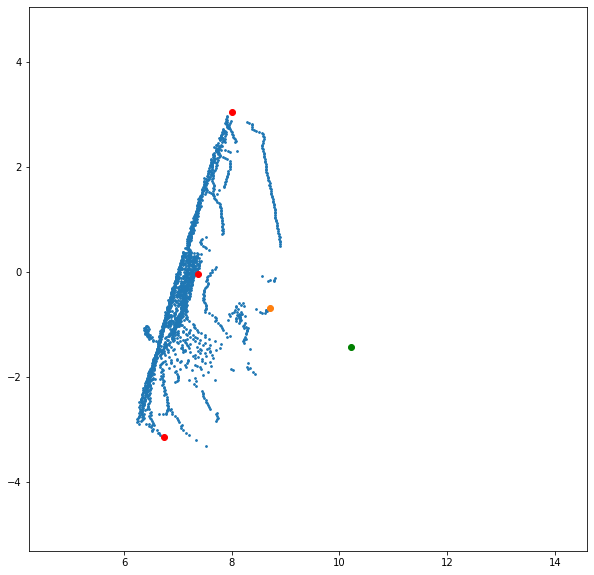

In [755]:
plt.figure(figsize=(10,10))
plt.scatter(Ground_truth_coord[:,0],Ground_truth_coord[:,1],s = 3)
plt.scatter(point_a[0],point_a[1],c = 'r')
plt.scatter(point_b[0],point_b[1],c = 'r')
plt.scatter(ab_center[0],ab_center[1],c = 'r')
# plt.scatter(rotated_cir[:,0],rotated_cir[:,1],c = 'g',s = 2)
plt.scatter(Ground_truth_coord[np.argmax(p_dis),0],Ground_truth_coord[np.argmax(p_dis),1])
plt.scatter(point_p[0],point_p[1],c = 'g')
x_min,x_max = Ground_truth_coord[:,0].min(),Ground_truth_coord[:,0].max()
y_min,y_max = Ground_truth_coord[:,1].min(),Ground_truth_coord[:,1].max()
scale = x_max - x_min
if (y_max - y_min) > scale:
    scale = y_max - y_min
plt.xlim(x_min-2 , x_min + scale + 2)
plt.ylim(y_min-2, y_min + scale +2)
plt.show()

In [ ]:
Ground_truth_coord[:,0],Ground_truth_coord[:,1]

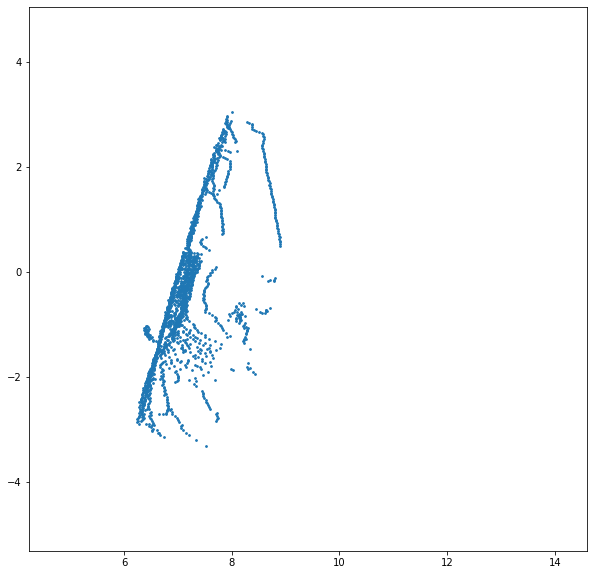

In [756]:
plt.figure(figsize=(10,10))
plt.scatter(Ground_truth_coord[:,0],Ground_truth_coord[:,1],s = 3)
x_min,x_max = Ground_truth_coord[:,0].min(),Ground_truth_coord[:,0].max()
y_min,y_max = Ground_truth_coord[:,1].min(),Ground_truth_coord[:,1].max()
scale = x_max - x_min
if (y_max - y_min) > scale:
    scale = y_max - y_min
plt.xlim(x_min-2 , x_min + scale + 2)
plt.ylim(y_min-2, y_min + scale +2)
plt.show()

In [191]:
%%timeit
rect = _rectangle_search(XY)

36 ms ± 716 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [188]:
Ground_truth_coord = XYZ[Labels == 0][:,:2]
rect = _rectangle_search(XY)

In [189]:
rect.calc_rect_contour()

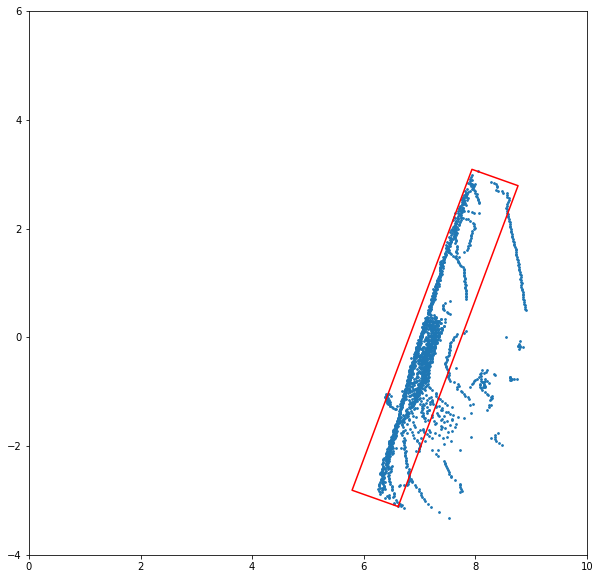

In [192]:
plt.figure(figsize=(10,10))
plt.scatter(Ground_truth_coord[:,0],Ground_truth_coord[:,1],s = 3)
plt.plot(rect.rect_c_x,rect.rect_c_y,c = 'r')
plt.xlim(0,10)
plt.ylim(-4,6)
plt.show()